<a href="https://colab.research.google.com/github/luthierman/quantum-research/blob/main/cartpole_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.3.1
!pip install gym

In [ ]:
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32) (4,)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
output (Dense)               (None, 2)                 18        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Checking if /content/drive/MyDrive/quantum_research/classical_models/dCDQN-2021-04-27_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9 exists...
finished!
/content/drive/MyDrive/quantum_research/classical_models/dCDQN-2021-04-27_58_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9
Episode 0/1000 || Best averag

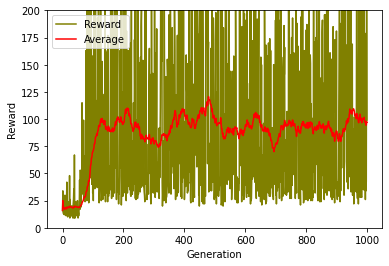

In [ ]:

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import datetime
import time
class DQN_AGENT(object):
    def __init__(self, action_size, state_size, batch_size, layers):
        self.action_space = action_size
        self.state_space = state_size[0]
        self.layers = layers
        self.q_network = self.make_net(self.state_space, self.layers)
        self.buff = 10000
        self.states = np.zeros((self.buff, self.state_space))
        self.actions = np.zeros((self.buff, 1))
        self.rewards = np.zeros((self.buff, 1))
        self.dones = np.zeros((self.buff, 1))
        self.next_states = np.zeros((self.buff, self.state_space))
        self.counter = 0
        self.batch = batch_size
        # Q Learning Parameters
        self.gamma = 0.95 # DISCOUNT FACTOR, CLOSE TO 1 = LONG TERM
        self.epsilon = 1.0 # Exploration rate
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.learning_rate = .01
        self.opt = tf.keras.optimizers.Adam(self.learning_rate)
        self.msbe = None
        #name and path
        self.date = datetime.date.today()
        self.model_name = "CDQN-{date}_{p}_ADAM_lr{lr}_g{g}_eps{ep}_epsmin{epmin}_epsd{epd}".format(
            date=self.date,
            g=self.gamma, 
            lr=self.learning_rate,
            p = self.q_network.count_params(),
            ep=self.epsilon,
            epmin=self.epsilon_min,
            epd=self.epsilon_decay)
        
    def make_net(self, state, layers):
        inputs = tf.keras.layers.Input(shape=(state))
        if layers == 1:
          x = tf.keras.layers.Dense(8, activation='relu')(inputs)
        if layers == 2:
          x = tf.keras.layers.Dense(32, activation='relu')(inputs)
        elif layers == 3:
          x = tf.keras.layers.Dense(32, activation='relu')(inputs)
          x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(self.action_space, name='output')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=x)
        model.summary()
        return model

    def remember(self, state, action, reward, next_state, done):
        i = self.counter % self.buff
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.next_states[i] = next_state
        self.dones[i] = int(done)
        self.counter += 1

    def get_action(self, obs):
        if random.random() < self.epsilon: 
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_network(np.array([obs]))[0])

    def train(self):
        batch_indices = np.random.choice(min(self.counter, self.buff), self.batch)
        state_batch = tf.convert_to_tensor(self.states[batch_indices])
        action_batch = tf.convert_to_tensor(self.actions[batch_indices].flatten(), dtype=tf.int32)
        action_batch = [[i, action_batch[i]] for i in range(len(action_batch))]
        reward_batch = tf.convert_to_tensor(self.rewards[batch_indices], dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_states[batch_indices])
        dones_batch = tf.convert_to_tensor(self.dones[batch_indices], dtype=tf.float32)
        reward_batch = tf.reshape(reward_batch, [len(reward_batch), 1])
        dones_batch = tf.reshape(dones_batch, [len(dones_batch), 1])

        with tf.GradientTape() as tape:
            next_q = self.q_network(next_state_batch)
            y = reward_batch + (1 - dones_batch) * self.gamma * next_q
            q = self.q_network(state_batch, training=True)
            target = tf.reshape(tf.gather_nd(y, action_batch), [self.batch, 1])
            pred = tf.gather_nd(q, action_batch)
            pred = tf.reshape(pred, [self.batch, 1])
            msbe = tf.math.reduce_mean(tf.math.square(target - pred))
            self.msbe = msbe
        grads = tape.gradient(msbe, self.q_network.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.q_network.trainable_variables))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Hyperparameters
ITERATIONS = 1000
batch_size = 32
windows = 50
learn_delay = 1000

env = gym.make("CartPole-v0")
'''env.observation_space.shape'''
env.seed(0)
print(env.action_space)
print(env.observation_space, env.observation_space.shape)
agent = DQN_AGENT(env.action_space.n, env.observation_space.shape, batch_size, 1)
master_path = make_path("/content/drive/MyDrive/quantum_research/classical_models/", "d"+agent.model_name)
rewards = []
losses = []
cur_loss = 1
avg_reward = deque(maxlen=ITERATIONS)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)
epi_times = []
start_time = time.process_time()

for i in range(ITERATIONS):
    s1 = env.reset()
    total_reward = 0
    episode_losses=[]
    done = False
    episode_start = time.process_time()
    s1 = [0 if s < 0 else 1 for s in s1]
    while not done:
        action = agent.get_action(s1)
        s2, reward, done, info = env.step(action)
        total_reward += reward
        s2 = [0 if s < 0 else 1 for s in s2]
        agent.remember(s1, action, reward, s2, done)
        if agent.counter > learn_delay and done:
            agent.train()
            episode_losses.append(agent.msbe)
        if done:
            rewards.append(total_reward)
            rs.append(total_reward)
        s1 = s2
    avg = np.mean(rs)
    avg_reward.append(avg)
    if avg > best_avg_reward:
        best_avg_reward = avg
    if len(episode_losses)>0:
        EPISODE_LOSSES= np.asarray(episode_losses)
        AVERAGE_EPISODE_LOSS = np.mean(EPISODE_LOSSES)
        losses.append(AVERAGE_EPISODE_LOSS)
        cur_loss = AVERAGE_EPISODE_LOSS
    else:
        losses.append(cur_loss)
    epi_end = time.process_time() -episode_start
    epi_times.append(epi_end)
    print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}".format(i, ITERATIONS, best_avg_reward, total_reward))
reward_file = "{h}/rewards".format(h = master_path)
average_file = "{h}/averages".format(h=master_path)
times_file = "{h}/times".format(h=master_path)
loss_file = "{h}/loss".format(h=master_path)
# np.save(reward_file , np.asarray(rewards))
# np.save(average_file , np.asarray(avg_reward))
# np.save(times_file , np.asarray(epi_times))
# np.save(loss_file , np.asarray(losses))
plt.ylim(0,200)
plt.plot(rewards, color='olive', label='Reward')
plt.plot(avg_reward, color='red', label='Average')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.show()

In [ ]:
c1r=np.asarray(rewards)
c1ar = np.asarray(avg_reward)
c1t = np.asarray(epi_times)
c1l = np.asarray(losses)

In [ ]:
c2r=np.asarray(rewards)
c2ar = np.asarray(avg_reward)
c2t = np.asarray(epi_times)
c2l = np.asarray(losses)

In [ ]:
c3r=np.asarray(rewards)
c3ar = np.asarray(avg_reward)
c3t = np.asarray(epi_times)
c3l = np.asarray(losses)

In [ ]:
q_path = "/content/drive/MyDrive/quantum_research/quantum_models/QDQN-2021-04-26_qbits4_ADAM_lr0.01_g0.95_eps1.0_epsmin0.01_epsd0.9/"
q4ar = np.load(q_path+"averages.npy")
q4r = np.load(q_path+"rewards.npy")
q4l = np.load(q_path+"loss.npy")
q4t = np.load(q_path+"times.npy")

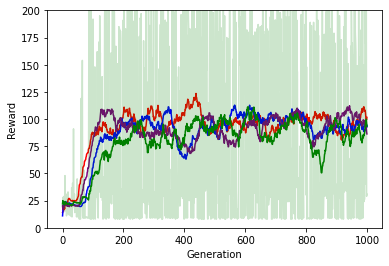

In [ ]:
plt.ylim(0,200)
# plt.plot(rewards, color='olive', label='Reward')
plt.plot(c1ar, color='red', label='Average NN1')
plt.plot(c2ar, color='blue', label='Average NN2')
plt.plot(c3ar, color='purple', label='Average NN3')
plt.plot(q4ar, color = "green", label = "Average Q4")
plt.plot(q4r, color = "green", alpha = .2, label ="R Q4")
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.show()

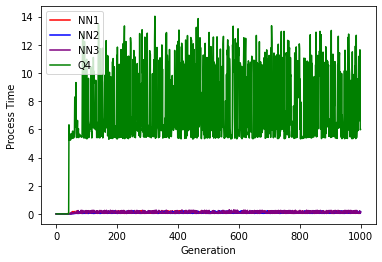

In [ ]:

plt.plot(c1t, color='red', label='NN1')
plt.plot(c2t, color='blue', label='NN2')
plt.plot(c3t, color='purple', label='NN3')
plt.plot(q4t, color='green', label='Q4')
plt.legend()
plt.ylabel('Process Time')
plt.xlabel('Generation')
plt.show()

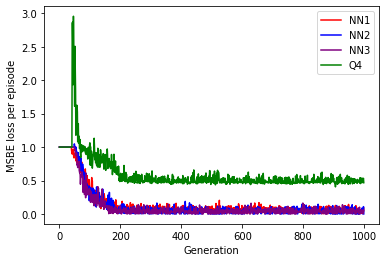

In [ ]:
plt.plot(c1l, color='red', label='NN1')
plt.plot(c2l, color='blue', label='NN2')
plt.plot(c3l, color='purple', label='NN3')
plt.plot(q4l, color = "green", label = "Q4")
plt.legend()
plt.ylabel('MSBE loss per episode')
plt.xlabel('Generation')
plt.show()